# Time Series: Stock Market Prediction

**Author**: Jvachier <br>
**Date**: 2023 <br>


To analyse and predict time series, I am using three different machine learning algorithms: Convolutional Neural Network (Conv1D), Recurrent Neural Network (LSTM) and Gated Recurrent Unit (GRU). 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/massive-yahoo-finance-dataset/stock_details_5_years.csv




Company: AAPL


LSTM - Fold:  1, Acc.: 0.000, Loss: 0.003
Conv1D - Fold:  1, Acc.: 0.000, Loss: 0.001
GRU - Fold:  1, Acc.: 0.0000, Loss: 0.0003
LSTM - Fold:  2, Acc.: 0.000, Loss: 0.000
Conv1D - Fold:  2, Acc.: 0.000, Loss: 0.000
GRU - Fold:  2, Acc.: 0.0000, Loss: 0.0001
LSTM - Fold:  3, Acc.: 0.000, Loss: 0.000
Conv1D - Fold:  3, Acc.: 0.000, Loss: 0.002
GRU - Fold:  3, Acc.: 0.0000, Loss: 0.0003
LSTM - Fold:  4, Acc.: 0.000, Loss: 0.000
Conv1D - Fold:  4, Acc.: 0.000, Loss: 0.001
GRU - Fold:  4, Acc.: 0.0000, Loss: 0.0003
LSTM - Fold:  5, Acc.: 0.000, Loss: 0.002
Conv1D - Fold:  5, Acc.: 0.000, Loss: 0.001
GRU - Fold:  5, Acc.: 0.0000, Loss: 0.0009
LSTM - Fold:  6, Acc.: 0.000, Loss: 0.002
Conv1D - Fold:  6, Acc.: 0.000, Loss: 0.002
GRU - Fold:  6, Acc.: 0.0000, Loss: 0.0014
LSTM - Fold:  7, Acc.: 0.000, Loss: 0.000
Conv1D - Fold:  7, Acc.: 0.000, Loss: 0.001
GRU - Fold:  7, Acc.: 0.0000, Loss: 0.0003
LSTM - Fold:  8, Acc.: 0.000, Loss: 0.000
Conv1D - Fold:  8, Acc.: 0.000, Loss:

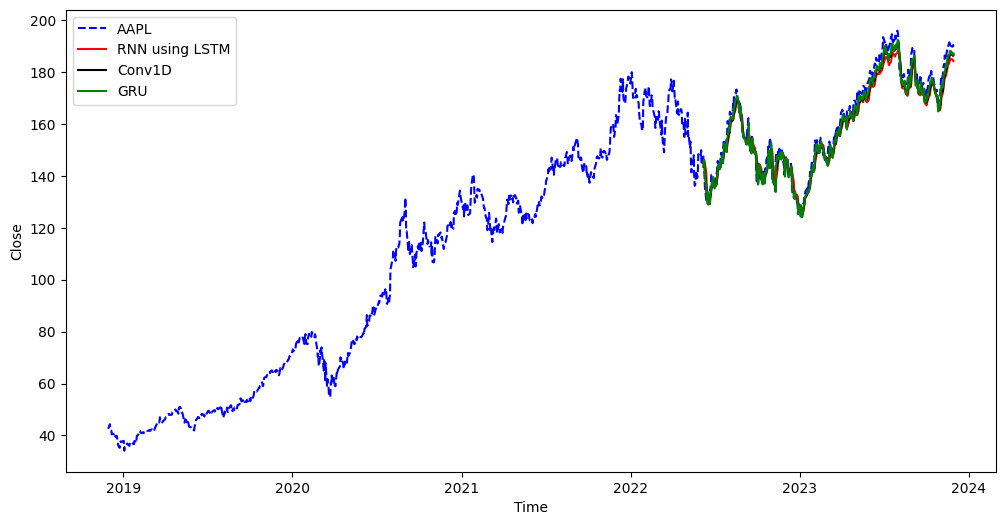



Company: ARES


LSTM - Fold:  1, Acc.: 0.000, Loss: 0.003
Conv1D - Fold:  1, Acc.: 0.000, Loss: 0.001
GRU - Fold:  1, Acc.: 0.0000, Loss: 0.0001
LSTM - Fold:  2, Acc.: 0.000, Loss: 0.000
Conv1D - Fold:  2, Acc.: 0.000, Loss: 0.000
GRU - Fold:  2, Acc.: 0.0000, Loss: 0.0001
LSTM - Fold:  3, Acc.: 0.000, Loss: 0.000
Conv1D - Fold:  3, Acc.: 0.000, Loss: 0.001
GRU - Fold:  3, Acc.: 0.0000, Loss: 0.0002
LSTM - Fold:  4, Acc.: 0.000, Loss: 0.000
Conv1D - Fold:  4, Acc.: 0.000, Loss: 0.001
GRU - Fold:  4, Acc.: 0.0000, Loss: 0.0003
LSTM - Fold:  5, Acc.: 0.000, Loss: 0.000
Conv1D - Fold:  5, Acc.: 0.000, Loss: 0.000
GRU - Fold:  5, Acc.: 0.0000, Loss: 0.0001
LSTM - Fold:  6, Acc.: 0.000, Loss: 0.000
Conv1D - Fold:  6, Acc.: 0.000, Loss: 0.000
GRU - Fold:  6, Acc.: 0.0000, Loss: 0.0001
LSTM - Fold:  7, Acc.: 0.000, Loss: 0.000
Conv1D - Fold:  7, Acc.: 0.000, Loss: 0.001
GRU - Fold:  7, Acc.: 0.0000, Loss: 0.0002
LSTM - Fold:  8, Acc.: 0.000, Loss: 0.000
Conv1D - Fold:  8, Acc.: 0.000, Loss:

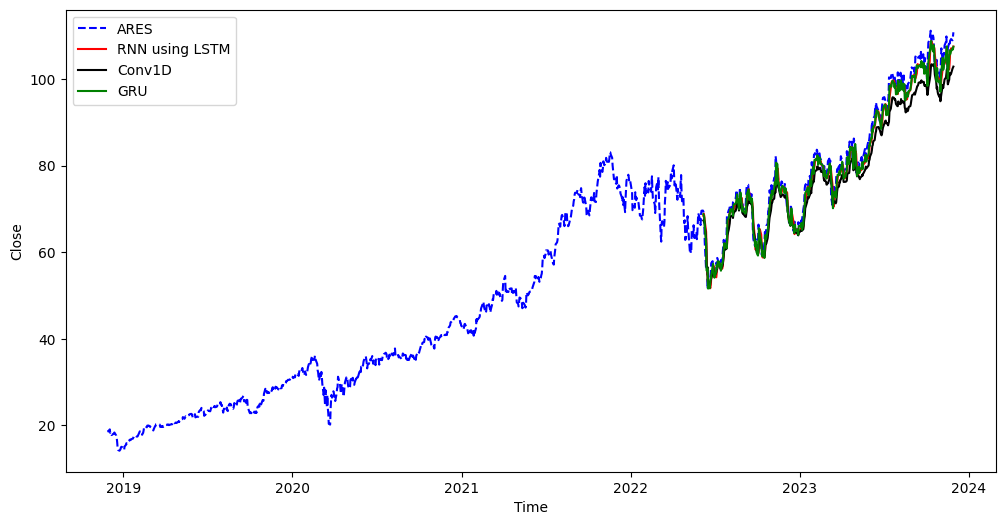

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras.layers import Conv1D, GRU
from tensorflow.keras.optimizers.legacy import Adam

from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import TimeSeriesSplit



class Timeseries():
    def __init__(self, data: pd.DataFrame, company: str):
        self.data: pd.DataFrame = data
        self.company: str = company
    
    def prepare_data(self) -> pd.DataFrame:
        self.scaler = MinMaxScaler()
        df = self.data[self.data['Company'] == self.company]
        df = df.dropna()
        df['Date'] = pd.to_datetime(df['Date'])
        columns = df.columns
        df = df.drop(columns=columns[5:])
        cols = ['Close']
        self.old_df = df[cols].shape 
        df[cols] = self.scaler.fit_transform(df[cols].to_numpy().reshape(-1,1)).reshape(self.old_df)
        return df

    def split_sequence(self, sequence: pd.Series, n_steps_in: int, n_steps_out: int) -> np.array:
        X, y = list(), list()
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            # check if we are beyond the sequence
            if out_end_ix > len(sequence):
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    def train_test_split(self,df) -> pd.DataFrame:
        train_size = int(len(df) * 0.7)
        test_size = len(df) - train_size
        train_df, test_df = df[0:train_size], df[train_size:len(df)]     
        return train_df, test_df
    
    def mondels(self, n_steps_in: int, n_steps_out: int, n_features: int):
        self.model_Conv1D = Sequential()
        self.model_Conv1D.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps_in,n_features)))
        self.model_Conv1D.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        self.model_Conv1D.add(Flatten())
        self.model_Conv1D.add(Dense(n_steps_out))
        self.model_Conv1D.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])

        self.model_GRU = Sequential()
        self.model_GRU.add(GRU(200, return_sequences=True, input_shape=(n_steps_in, n_features)))
        self.model_GRU.add(GRU(200, return_sequences=True))
        self.model_GRU.add(GRU(200, return_sequences=True))
        self.model_GRU.add(GRU(200))
        self.model_GRU.add(Dense(n_steps_out))
        self.model_GRU.compile(optimizer=Adam(learning_rate=0.0001),loss='mse', metrics=['accuracy'])

        self.model_LSTM = Sequential()
        self.model_LSTM.add(LSTM(200, return_sequences=True, input_shape=(n_steps_in, n_features)))
        self.model_LSTM.add(LSTM(200, return_sequences=True))
        self.model_LSTM.add(LSTM(200, return_sequences=True))
        self.model_LSTM.add(LSTM(200))
        self.model_LSTM.add(Dense(n_steps_out))
        self.model_LSTM.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])
     
    def train_models(self, X_train: np.array, y_train: np.array) -> None:
        scores_LSTM = []
        scores_Conv1D = []
        scores_GRU = []

        timefold = TimeSeriesSplit(n_splits=10).split(X_train,y_train)
        for k, (train, test) in enumerate(timefold):
            self.model_LSTM.fit(
                X_train[train], 
                y_train[train], 
                epochs=50, 
                verbose=0, 
                validation_split=0.3,
            )
            score_LSTM = self.model_LSTM.evaluate(
                X_train[test], 
                y_train[test], 
                verbose=0, 
            )
            scores_LSTM.append(score_LSTM)
            print('LSTM - Fold: %2d, Acc.: %.3f, Loss: %.3f' % (k+1,score_LSTM[1],score_LSTM[0]))

            self.model_Conv1D.fit(
                X_train[train], 
                y_train[train], 
                epochs=50, 
                verbose=0, 
                validation_split=0.3, 
            )
            score_Conv1D = self.model_Conv1D.evaluate(
                X_train[test], 
                y_train[test], 
                verbose=0, 
            )
            scores_Conv1D.append(score_Conv1D)
            print('Conv1D - Fold: %2d, Acc.: %.3f, Loss: %.3f' % (k+1,score_Conv1D[1],score_Conv1D[0]))

            self.model_GRU.fit(
                X_train[train], 
                y_train[train], 
                epochs=50, 
                verbose=0, 
                validation_split=0.3, 
            )
            score_GRU = self.model_GRU.evaluate(
                X_train[test], 
                y_train[test], 
                verbose=0, 
            )
            scores_GRU.append(score_GRU)
            print('GRU - Fold: %2d, Acc.: %.4f, Loss: %.4f' % (k+1,score_GRU[1],score_GRU[0]))  
    
    def test_prediction(self, x_input: np.array, df: pd.DataFrame) -> pd.DataFrame:
        yhat_LSTM = self.model_LSTM.predict(x_input, verbose=0)
        yhat_Conv1D = self.model_Conv1D.predict(x_input, verbose=0)
        yhat_GRU = self.model_GRU.predict(x_input, verbose=0)
        
        mean_LSTM = np.mean(yhat_LSTM,axis=1)
        mean_Conv1D = np.mean(yhat_Conv1D,axis=1)
        mean_GRU = np.mean(yhat_GRU,axis=1)

        mean_LSTM = self.scaler.inverse_transform(mean_LSTM.reshape(-1,1)).reshape(len(mean_LSTM),)
        mean_Conv1D = self.scaler.inverse_transform(mean_Conv1D.reshape(-1,1)).reshape(len(mean_Conv1D),)
        mean_GRU = self.scaler.inverse_transform(mean_GRU.reshape(-1,1)).reshape(len(mean_GRU),)

        df['Close'] = self.scaler.inverse_transform(df['Close'].to_numpy().reshape(-1,1)).reshape(self.old_df)
        return mean_LSTM, mean_Conv1D, mean_GRU, df

    def figure(self, df: pd.DataFrame,test_df: pd.DataFrame, LSTM: pd.DataFrame, Conv1D: pd.DataFrame, GRU: pd.DataFrame, n_steps_in: int):
        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'],df['Close'],'--b',label=self.company)
        plt.plot(test_df['Date'][n_steps_in:],LSTM,'r',label='RNN using LSTM')
        plt.plot(test_df['Date'][n_steps_in:],Conv1D,'k',label='Conv1D')
        plt.plot(test_df['Date'][n_steps_in:],GRU,'g',label='GRU')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Close')
        plt.show()

def main():
    n_steps_in, n_steps_out, n_features = 5, 1, 1

    df = pd.read_csv('/kaggle/input/massive-yahoo-finance-dataset/stock_details_5_years.csv')

    print('\n')
    print('Company: AAPL')
    print('\n')
    AAPL = Timeseries(df,'AAPL')

    ARES = Timeseries(df,'ARES')

    df_AAPL = AAPL.prepare_data()
    train_df_AAPL, test_df_AAPL = AAPL.train_test_split(df_AAPL)

    X_train_AAPL, y_train_AAPL = AAPL.split_sequence(train_df_AAPL['Close'], n_steps_in, n_steps_out)
    X_test_AAPL, y_test_AAPL = AAPL.split_sequence(test_df_AAPL['Close'], n_steps_in, n_steps_out)
    
    X_train_AAPL = X_train_AAPL.reshape((X_train_AAPL.shape[0], X_train_AAPL.shape[1], n_features))
    x_input_AAPL = X_test_AAPL.reshape((X_test_AAPL.shape[0], X_test_AAPL.shape[1], n_features))

    AAPL.mondels(n_steps_in,n_steps_out,n_features)
    AAPL.train_models(X_train_AAPL, y_train_AAPL)

    mean_LSTM, mean_Conv1D, mean_GRU, df = AAPL.test_prediction(x_input_AAPL, df_AAPL)

    AAPL.figure(df,test_df_AAPL,mean_LSTM, mean_Conv1D, mean_GRU,n_steps_in)

    print('\n')
    print('Company: ARES')
    print('\n')
    
    df_ARES = ARES.prepare_data()
    train_df_ARES, test_df_ARES = ARES.train_test_split(df_ARES)

    X_train_ARES, y_train_ARES = ARES.split_sequence(train_df_ARES['Close'], n_steps_in, n_steps_out)
    X_test_ARES, y_test_ARES = ARES.split_sequence(test_df_ARES['Close'], n_steps_in, n_steps_out)
    
    X_train_ARES = X_train_ARES.reshape((X_train_ARES.shape[0], X_train_ARES.shape[1], n_features))
    x_input_ARES = X_test_ARES.reshape((X_test_ARES.shape[0], X_test_ARES.shape[1], n_features))

    ARES.mondels(n_steps_in,n_steps_out,n_features)
    ARES.train_models(X_train_ARES, y_train_ARES)

    mean_LSTM, mean_Conv1D, mean_GRU, df = ARES.test_prediction(x_input_ARES, df_ARES)

    ARES.figure(df,test_df_ARES,mean_LSTM, mean_Conv1D, mean_GRU,n_steps_in)

    

if __name__ == "__main__":
    main()